Loaded checkpoint from epoch 1


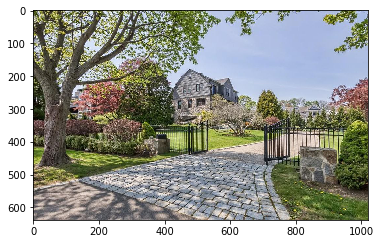

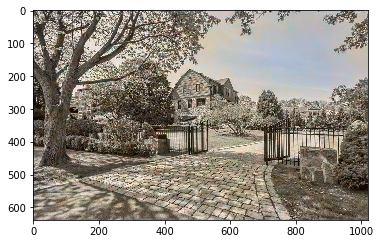

In [84]:
import cv2
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from model import Net 

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = Image.open('test.jpg')
plt.figure(0)
plt.imshow(img)
test_img = transform_test(img)

# rgb -> lab
lab = torch.from_numpy(rgb2lab(test_img.permute(1, 2, 0))).float()
l = lab[:, :, 0:1]
# # normalize a&b to [0, 1]
ab = (lab[:, :, 1:] + 128) / 255

# load model
model = Net()
checkpoint = torch.load('running_checkpoint.pth.tar')
start_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
model.load_state_dict(checkpoint['state_dict'])
print('Loaded checkpoint from epoch %d' % start_epoch)
model.eval()

# predict colors
with torch.no_grad():
    inputs = l.unsqueeze(0)
    color_preds, label_preds = model(inputs)
    color_preds = color_preds * 255 - 128
    l_orig = torch.from_numpy(rgb2lab(transforms.ToTensor()(img).permute(1, 2, 0)))[:, :, 0:1].float()
    color_preds = F.interpolate(color_preds.permute(0, 3, 1, 2), size=(l_orig.size(0), l_orig.size(1)), mode='nearest')
    color_preds = color_preds.permute(0, 2, 3, 1)  
    colorization_lab = torch.cat((l_orig, color_preds[0]), -1)
    colorization_rgb = lab2rgb(colorization_lab.double())

plt.figure(1)
plt.imshow(colorization_rgb)